<a href="https://colab.research.google.com/github/Gebreyowhans/Deep_Learning/blob/main/FunctionalAPI_In_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
from os import name
inputs=keras.Input(shape=(3,),name="InputData")
features=layers.Dense(64,activation="relu")(inputs)
outputs=layers.Dense(10,activation="softmax")(features)
model=keras.Model(inputs=inputs,outputs=outputs,name="Functional Model")


In [5]:
model.summary()

Model: "Functional Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputData (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**A multi-input, multi-output Functional model to rank customer support
tickets by priority and route them to the appropriate
department.**

In [3]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

In [4]:
# Define model inputs.
title=keras.Input(shape=(vocabulary_size,),name="title")
text_body=keras.Input(shape=(vocabulary_size,),name="text_body")
tags=keras.Input(shape=(num_tags,),name="tags")

#Combine input features into a single tensor, features, by concatenating them.
features=layers.Concatenate()([title,text_body,tags])

#Apply an intermediate layer to recombine input features into richer representations.
features=layers.Dense(64,activation="relu")(features)

# Define model outputs.
priority=layers.Dense(1,activation="sigmoid",name="priority")(features)
department=layers.Dense(num_departments,activation="softmax",name="department")(features)

# Create the model by specifying its inputs and outputs.The Functional
model=keras.Model(inputs=[title,text_body,tags],outputs=[priority,department])

**Training the functional model by providing lists of input and target arrays**

In [5]:
import numpy as np
num_samples = 1280

In [7]:
# Dummy input data
title_data=np.random.randint(0,2,size=(num_samples,vocabulary_size))
text_body_data=np.random.randint(0,2,size=(num_samples,vocabulary_size))
tags_data=np.random.randint(0,2,size=(num_samples,num_tags))

# Dummy target data
priority_data=np.random.random(size=(num_samples,1))
department_data=np.random.randint(0,2,size=(num_samples,num_departments))

#Compile the model
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])


In [9]:
title_data[:10]
title_data.shape

(1280, 10000)

In [11]:
text_body_data[:10]
text_body_data.shape

(1280, 10000)

In [13]:
tags_data[:10]
tags_data.shape

(1280, 100)

In [15]:
priority_data[:10]
priority_data.shape

(1280, 1)

In [17]:
department_data[:10]
department_data.shape

(1280, 4)

In [19]:
# Fit the model
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

40/40 [==============================] - 2s 19ms/step - loss: 25.6493 - priority_loss: 0.3255 - department_loss: 25.3238 - priority_mean_absolute_error: 0.4907 - department_accuracy: 0.2492


In [20]:
#Evaluate the model
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

40/40 [==============================] - 1s 11ms/step - loss: 25.5103 - priority_loss: 0.3383 - department_loss: 25.1720 - priority_mean_absolute_error: 0.5035 - department_accuracy: 0.0609


[25.510324478149414,
 0.33834439516067505,
 25.171981811523438,
 0.5035208463668823,
 0.06093750149011612]

In [21]:
# get predictions
priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data])

40/40 [==============================] - 1s 10ms/step


**Training a model by providing dicts of input and target arrays**

In [22]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department":"categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department":["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data,
           "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data,
                "tags": tags_data},
               {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 8ms/step


**THE POWER OF THE FUNCTIONAL API: ACCESS TO LAYER CONNECTIVITY**

***Let’s now visualize the connectivity of the model we just defined (the topology of the model) using plot_model()***

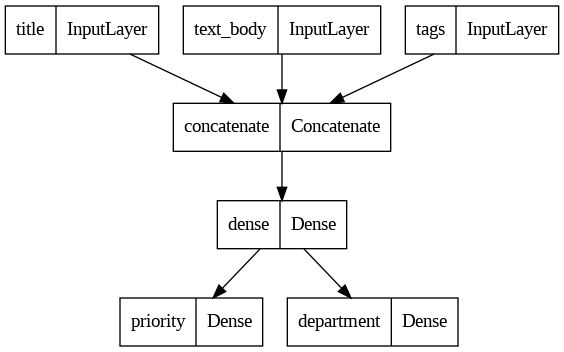

In [23]:
keras.utils.plot_model(model,"ticket_classifier.png")

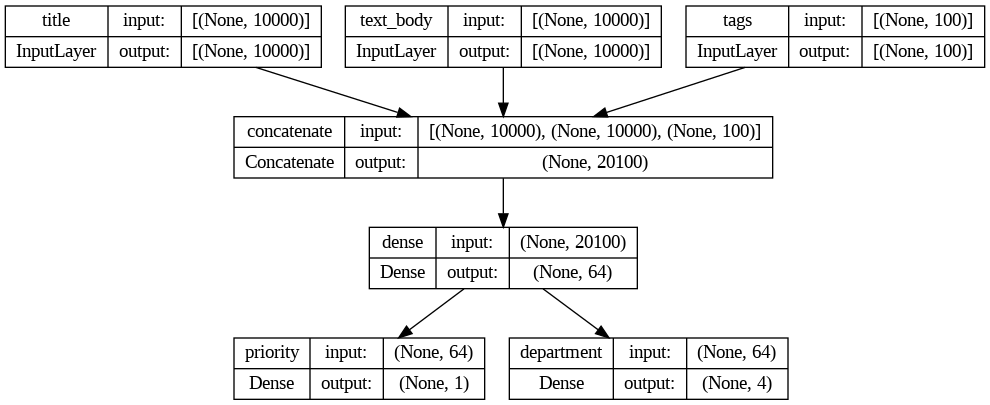

In [24]:
# adjust the plot so that it includes shapes of input and output data
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

**Note : The “None” in the tensor shapes represents the batch size:
this model allows batches of any size.**

*Access to layer connectivity also means that you can inspect and reuse individual nodes (layer calls) in the graph. The
**model.layers** model property provides the list of layers
that make up the model, and for each layer we can query
**layer.input** and **layer.output**.*

In [25]:
model.layers

In [27]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [28]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

*This enables us to do **feature extraction**, creating models
that reuse intermediate features from another model.*


# Feature Extraction
Let’s say we want to add another output to the previous model—you want to estimate how long a given issue ticket will take to resolve, a kind of difficulty rating. we could do this via a classification layer over three categories: “quick,” “medium,” and “difficult.” we don’t need to recreate and
retrain a model from scratch. We can start from the
intermediate features of our previous model, since we
have access to them, like the below.



In [30]:
# Creating a new model by reusing intermediate layer outputs

features=model.layers[4].output # layer[4] is our intermediate Dense layer
difficulty=layers.Dense(3,activation="softmax",name="difficulty")(features)

new_model=keras.Model(inputs=[title, text_body, tags],
                      outputs=[priority, department, difficulty])

**Let’s now plot our new model**

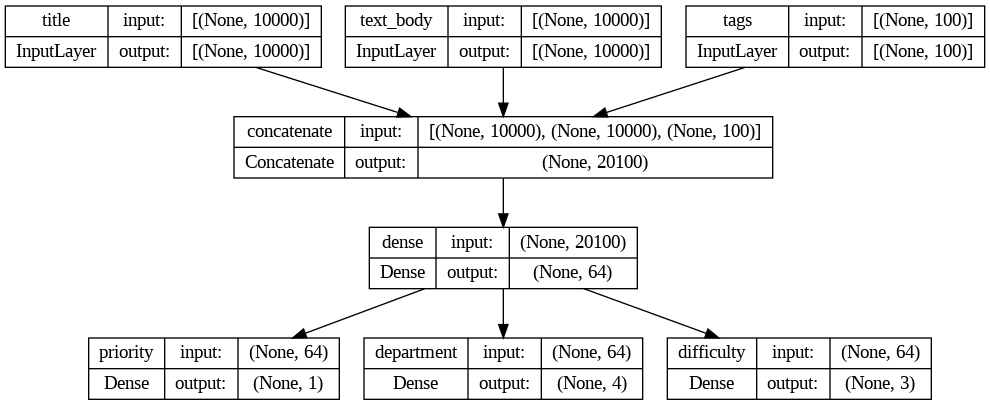

In [31]:
keras.utils.plot_model(new_model,"updated_ticket_classifier.png",show_shapes=True)